In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/My_Colab_Notebooks/Deep_Learning_Class/TA/Transformers/Solution/exchange_rate.txt'
with open(data_path, 'r') as file:
    lines = file.readlines()

# Split each line into individual exchange rates
data = [line.strip().split(',') for line in lines]

# Create a DataFrame
df = pd.DataFrame(data)

# Assign column names
column_names = ['Australia', 'British', 'Canada', 'Switzerland', 'China', 'Japan', 'New Zealand', 'Singapore']
df.columns = column_names

# Optionally, convert exchange rates to numeric values
df = df.astype(float)

# Print the first few rows of the DataFrame
print(df.head())

   Australia  British    Canada  Switzerland     China     Japan  New Zealand  \
0     0.7855   1.6110  0.861698     0.634196  0.211242  0.006838       0.5930   
1     0.7818   1.6100  0.861104     0.633513  0.211242  0.006863       0.5940   
2     0.7867   1.6293  0.861030     0.648508  0.211242  0.006975       0.5973   
3     0.7860   1.6370  0.862069     0.650618  0.211242  0.006953       0.5970   
4     0.7849   1.6530  0.861995     0.656254  0.211242  0.006940       0.5985   

   Singapore  
0   0.525486  
1   0.523972  
2   0.526316  
3   0.523834  
4   0.527426  


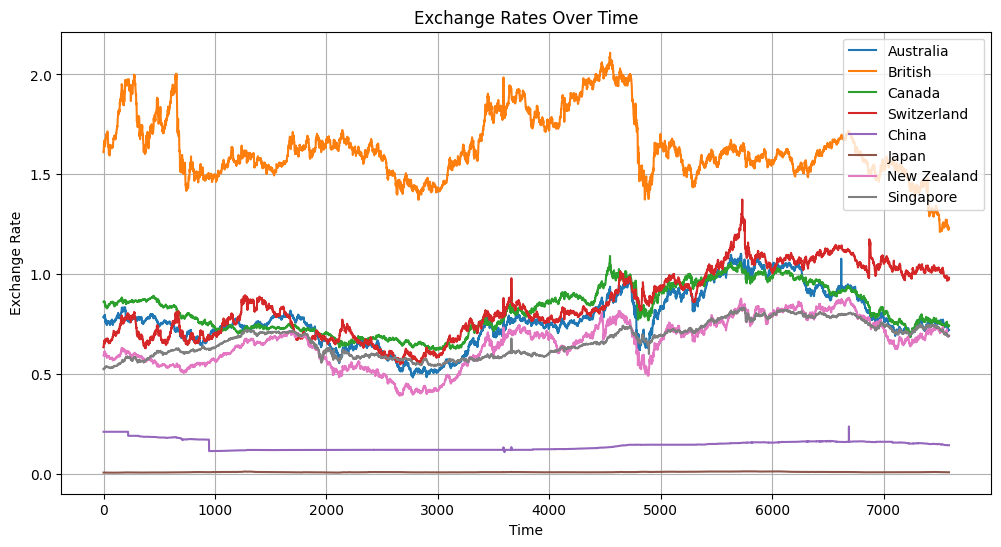

In [ ]:
# Plotting the exchange rates over time
plt.figure(figsize=(12, 6))

# Plot each currency exchange rate
for currency in df.columns:
    plt.plot(df.index, df[currency], label=currency)

plt.title('Exchange Rates Over Time')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


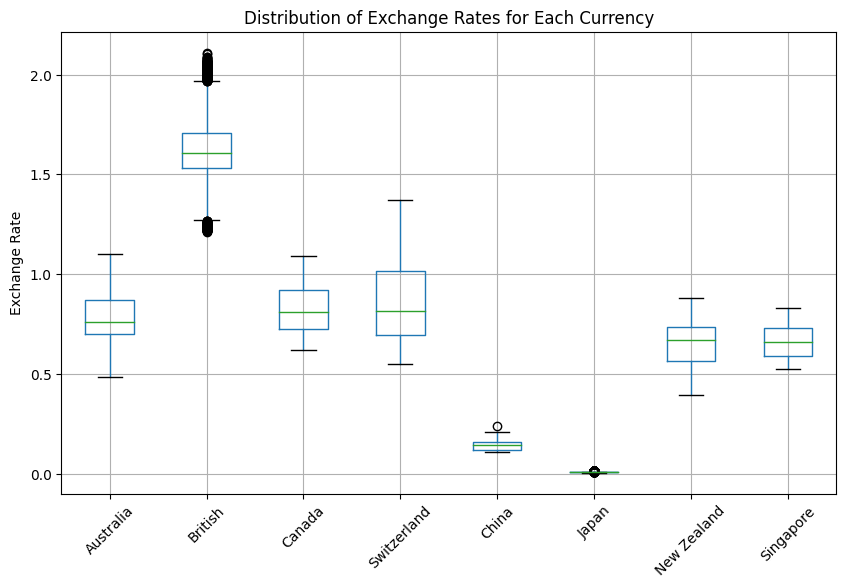

In [ ]:
# Box plot of exchange rates for each currency
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Distribution of Exchange Rates for Each Currency')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Get the size of the dataset
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 7588
Number of columns: 8


In [ ]:
# Define custom dataset class
class ExchangeRateDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - (self.input_len + self.output_len) + 1

    def __getitem__(self, idx):
        idx_end = idx + self.input_len
        input_seq = self.data[idx:idx_end]
        output_seq = self.data[idx_end:idx_end+self.output_len]
        return input_seq, output_seq

In [ ]:
# Assuming df is your DataFrame containing the exchange rate data
input_dim = 10  # Lookback time series length
output_dim = 1  # Predicted length
variates_num = 8  # Number of variates
token_dim = variates_num  # Token dimension
var_dim = 16
hidden_dim = 4
num_layers = 2  # Number of Transformer FF layers
num_blocks = 3  # Number of Transformer blocks
batch_size = 64
epochs = 10
data = df.values

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Create DataLoader for train and test sets
train_dataset = ExchangeRateDataset(train_data, input_dim, output_dim)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ExchangeRateDataset(test_data, input_dim, output_dim)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define custom Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, token_dim, hidden_dim, num_blocks, num_layers):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.token_dim = token_dim

        # Define self-attention layers
        self.self_attns = nn.ModuleList([
            MultiHeadAttention(input_dim, token_dim, num_heads=4) for _ in range(num_blocks)
        ])

        # Define feed-forward layers
        self.ffns = nn.ModuleList([
            FeedForward(token_dim, hidden_dim, output_dim) for _ in range(num_layers)
        ])

        # Define layer normalization
        self.layer_norms1 = nn.ModuleList([nn.LayerNorm(token_dim) for _ in range(num_blocks)])
        self.layer_norms2 = nn.ModuleList([nn.LayerNorm(token_dim) for _ in range(num_layers)])

        # Define output linear layer
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):

        for self_attn, ffn, layer_norm1, layer_norm2 in zip(self.self_attns, self.ffns, self.layer_norms1, self.layer_norms2):
            src2 = self_attn(src, src, src)
            src = src + src2
            src = layer_norm1(src)
            src2 = ffn(src)
            src = src + src2
            src = layer_norm2(src)

        output = self.fc(src.permute(0, 2, 1))  # [batch_size, seq_len, token_dim]

        return output.permute(0, 2, 1)

# Define multi-head attention layer
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, token_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert token_dim % num_heads == 0
        self.input_dim = input_dim
        self.token_dim = token_dim
        self.num_heads = num_heads
        self.head_dim = token_dim // num_heads

        self.fc_query = nn.Linear(token_dim, token_dim)
        self.fc_key = nn.Linear(token_dim, token_dim)
        self.fc_value = nn.Linear(token_dim, token_dim)

    def forward(self, query, key, value):
        batch_size = query.shape[0]

        # Linear transformation for queries, keys, and values
        Q = self.fc_query(query)
        K = self.fc_key(key)
        V = self.fc_value(value)
        # Split into multiple heads
        Q = Q.view(batch_size, self.input_dim, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # [batch_size, num_heads, seq_len, head_dim]
        K = K.view(batch_size, self.input_dim, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, self.input_dim, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute scaled dot-product attention
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.head_dim)  # [batch_size, num_heads, seq_len, seq_len]
        attention_scores = F.softmax(energy, dim=-1)
        output = torch.matmul(attention_scores, V)  # [batch_size, num_heads, seq_len, head_dim]

        # Merge heads
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, self.input_dim, self.token_dim)  # [batch_size, seq_len, token_dim]

        return output

# Define feed-forward layer
class FeedForward(nn.Module):
    def __init__(self, token_dim, hidden_dim, output_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(token_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = TransformerModel(input_dim, output_dim, token_dim, hidden_dim, num_blocks, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")


Epoch 1, Loss: 0.971284672461058
Epoch 2, Loss: 0.44887814992352537
Epoch 3, Loss: 0.20416525194519444
Epoch 4, Loss: 0.08664239288160676
Epoch 5, Loss: 0.03880881553417758
Epoch 6, Loss: 0.021477895622190678
Epoch 7, Loss: 0.015672937025757214
Epoch 8, Loss: 0.013813328282221368
Epoch 9, Loss: 0.01317898944804543
Epoch 10, Loss: 0.012879965866082593


In [ ]:
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.float())
        all_predictions.append(outputs.numpy())
        all_targets.append(targets.float().numpy())

# Flatten predictions and targets
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_predictions = all_predictions.reshape(-1)
all_targets = all_targets.reshape(-1)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(all_targets, all_predictions)
print("Mean Squared Error (MSE):", mse)
mae = mean_absolute_error(all_targets, all_predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.02335477
Mean Absolute Error (MAE): 0.1132854


In [ ]:
# Define custom iTransformer model
class iTransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, batch_size, var_dim, token_dim, hidden_dim, num_blocks, num_layers):
        super(iTransformerModel, self).__init__()
        self.input_dim = input_dim
        self.token_dim = token_dim

        self.mlp = nn.Linear(batch_size, var_dim)
        self.mlpback = nn.Linear(var_dim, batch_size)

        # Define self-attention layers
        self.self_attns = nn.ModuleList([
            iMultiHeadAttention(input_dim, var_dim, token_dim, num_heads=4) for _ in range(num_blocks)
        ])

        # Define feed-forward layers
        self.ffns = nn.ModuleList([
            iFeedForward(var_dim, hidden_dim, output_dim) for _ in range(num_layers)
        ])

        # Define layer normalization
        self.layer_norms1 = nn.ModuleList([nn.LayerNorm(var_dim) for _ in range(num_blocks)])
        self.layer_norms2 = nn.ModuleList([nn.LayerNorm(var_dim) for _ in range(num_layers)])

        # Define output linear layer
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        src = self.mlp(src)
        for self_attn, ffn, layer_norm1, layer_norm2 in zip(self.self_attns, self.ffns, self.layer_norms1, self.layer_norms2):
            src2 = self_attn(src, src, src)
            src = src + src2
            src = layer_norm1(src)
            src2 = ffn(src)
            src = src + src2
            src = layer_norm2(src)

        output = self.mlpback(src).permute(2, 1, 0)

        output = self.fc(output)

        return output.permute(0, 2, 1)


# Define iMultiHeadAttention layer
class iMultiHeadAttention(nn.Module):
    def __init__(self, input_dim, var_dim, token_dim, num_heads):
        super(iMultiHeadAttention, self).__init__()
        assert token_dim % num_heads == 0
        self.input_dim = input_dim
        self.token_dim = token_dim
        self.num_heads = num_heads
        self.head_dim = var_dim // num_heads
        self.var_dim = var_dim
        self.fc_query = nn.Linear(var_dim, var_dim)
        self.fc_key = nn.Linear(var_dim, var_dim)
        self.fc_value = nn.Linear(var_dim, var_dim)

    def forward(self, query, key, value):

        # Linear transformation for queries, keys, and values
        Q = self.fc_query(query)
        K = self.fc_key(key)
        V = self.fc_value(value)

        # Split into multiple heads
        Q = Q.view(self.input_dim, self.token_dim, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # [seq_len, num_heads, token_dim, head_dim]
        K = K.view(self.input_dim, self.token_dim, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(self.input_dim, self.token_dim, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute scaled dot-product attention
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.head_dim)  # [seq_len, num_heads, token_dim, head_dim]
        attention_scores = F.softmax(energy, dim=-1)
        output = torch.matmul(attention_scores, V)  # [seq_len, num_heads, token_dim, head_dim]

        # Merge heads
        output = output.permute(0, 2, 1, 3).contiguous().view(self.input_dim, self.token_dim, self.var_dim)  # [seq_len, token_dim, var_dim]

        return output

# Define feed-forward layer
class iFeedForward(nn.Module):
    def __init__(self, var_dim, hidden_dim, output_dim):
        super(iFeedForward, self).__init__()
        self.fc1 = nn.Linear(var_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

i_model = iTransformerModel(input_dim, output_dim, batch_size, var_dim, token_dim, hidden_dim, num_blocks, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(i_model.parameters(), lr=0.001)

In [ ]:
# Training loop
for epoch in range(epochs):
    i_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = i_model(inputs.permute(1, 2, 0).float())
          loss = criterion(outputs, targets.float())
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")


Epoch 1, Loss: 0.4854995724401976
Epoch 2, Loss: 0.08340847868668405
Epoch 3, Loss: 0.02762601020696916
Epoch 4, Loss: 0.01679756177687331
Epoch 5, Loss: 0.015176916220470479
Epoch 6, Loss: 0.014642353463721903
Epoch 7, Loss: 0.01402390646307092
Epoch 8, Loss: 0.013843051295139288
Epoch 9, Loss: 0.013845269127111686
Epoch 10, Loss: 0.013709742222961627


In [ ]:
i_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        if inputs.shape[0] == batch_size:
          outputs = i_model(inputs.permute(1, 2, 0).float())
          all_predictions.append(outputs.numpy())
          all_targets.append(targets.float().numpy())

# Flatten predictions and targets
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_predictions = all_predictions.reshape(-1)
all_targets = all_targets.reshape(-1)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(all_targets, all_predictions)
print("Mean Squared Error (MSE):", mse)
mae = mean_absolute_error(all_targets, all_predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.004742596
Mean Absolute Error (MAE): 0.056313332
